In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [22]:
# challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
# customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
# submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
# trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
# market     = pd.read_csv(RAW/'Market.csv', low_memory=False)

In [3]:
week_labels = [20180226, 20180305, 20180312, 20180319, 
               20180326, 20180402, 20180409, 20180416, 20180423]

In [4]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'week_{name % 10000:04}_diffscountsprices.feather'))

CPU times: user 2.9 s, sys: 1.84 s, total: 4.74 s
Wall time: 4.78 s


In [7]:
for w in weeks:
    cols = [c for c in w if 'week' in c.lower()]
    w.drop(cols, axis=1, inplace=True)

In [9]:
from src.utils import date_diff

In [13]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    w['BondDuration']  = w.apply(lambda r: date_diff(r.ActualMaturityDateKey, r.IssueDateKey), axis=1)
    w['BondRemaining'] = w.apply(lambda r: date_diff(r.ActualMaturityDateKey, r.TradeDateKey), axis=1)
    w['BondLife']      = w.apply(lambda r: date_diff(r.TradeDateKey, r.IssueDateKey), axis=1)

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 4min 53s, sys: 6.29 s, total: 4min 59s
Wall time: 4min 59s


In [23]:
ratings = list(isin.CompositeRating.value_counts().index)

In [30]:
def composite_rating_cmp(x, y):
    if x[0] != y[0]: # A vs B
        return -1 if x[0] < y[0] else 1
    len_x = len([c for c in x if c.isalpha()])
    len_y = len([c for c in y if c.isalpha()])
    if len_x != len_y: # AAA vs AA
        return -1 if len_x > len_y else 1
    if x != y: # BB+ BB-
        if '+' in x:
            return -1 
        elif '+' in y:
            return 1
        else:
            return -1 if len(x) < len(y) else 1
    return 0

In [33]:
from functools import cmp_to_key
ratings = sorted(ratings, key=cmp_to_key(composite_rating_cmp), reverse=True)
rank = {k: i for i, k in enumerate(ratings)}

In [35]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    w['CompositeRatingRank']  = w.CompositeRating.apply(lambda x: rank[x])

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 1.61 s, sys: 12 ms, total: 1.62 s
Wall time: 1.61 s


In [37]:
%%time
for w, name in zip(weeks, week_labels):
    w.to_feather(PROCESSED/f'week_{name % 10000:04}_diffscountsprices_durationsranks.feather')

CPU times: user 9.21 s, sys: 2.12 s, total: 11.3 s
Wall time: 11.2 s


## Preprocessing

In [40]:
for w in weeks:
    w.drop('CompositeRating', axis=1, inplace=True)

In [43]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [44]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [45]:
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

## Model

In [46]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [47]:
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

[20180226] [20180305] [20180423]
[20180305] [20180312] [20180423]
[20180312] [20180319] [20180423]
[20180319] [20180326] [20180423]
[20180326] [20180402] [20180423]
[20180402] [20180409] [20180423]
[20180409] [20180416] [20180423]
[20180416] [20180423] [20180423]


In [48]:
%%time
results = None
output = []
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=120),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=120',
            dataset_desc=f'{week_labels[i]}_diffcounts', 
            early_stopping=True)
    output.append([y_test, model])

LGBMClassifier 

[1]	valid_0's auc: 0.598994
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.599803
[3]	valid_0's auc: 0.603941
[4]	valid_0's auc: 0.617156
[5]	valid_0's auc: 0.616071
[6]	valid_0's auc: 0.616719
[7]	valid_0's auc: 0.62494
[8]	valid_0's auc: 0.623669
[9]	valid_0's auc: 0.626621
[10]	valid_0's auc: 0.62471
[11]	valid_0's auc: 0.62601
[12]	valid_0's auc: 0.624708
[13]	valid_0's auc: 0.623084
[14]	valid_0's auc: 0.626208
[15]	valid_0's auc: 0.625078
[16]	valid_0's auc: 0.627219
[17]	valid_0's auc: 0.630172
[18]	valid_0's auc: 0.628899
[19]	valid_0's auc: 0.62812
[20]	valid_0's auc: 0.631729
[21]	valid_0's auc: 0.632956
[22]	valid_0's auc: 0.633672
[23]	valid_0's auc: 0.63721
[24]	valid_0's auc: 0.637045
[25]	valid_0's auc: 0.636751
[26]	valid_0's auc: 0.638965
[27]	valid_0's auc: 0.638356
[28]	valid_0's auc: 0.63707
[29]	valid_0's auc: 0.636832
[30]	valid_0's auc: 0.638422
[31]	valid_0's auc: 0.63942
[32]	valid_0's auc: 0.641654
[33]	vali

In [49]:
len(weeks)

9

In [50]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,11.13,0.800901,0.659268
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,7.22,0.753864,0.696520
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,9.36,0.796176,0.731158
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,9.90,0.793844,0.677724
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,8.75,0.792532,0.704271
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,7.16,0.791678,0.740145
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,9.57,0.830610,0.773274
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,5.47,0.844342,0.000000


In [51]:
# first 5 predictions (2018 data)
np.array([x[0] for x in output])[:,:5]

array([[0.04077412, 0.13307883, 0.02119768, 0.04709071, 0.01817244],
       [0.03561078, 0.10515225, 0.02773559, 0.08171216, 0.0301878 ],
       [0.03933046, 0.07855799, 0.0266732 , 0.08404442, 0.01392145],
       [0.02884778, 0.07126396, 0.02665433, 0.04752965, 0.02309568],
       [0.03422478, 0.09873875, 0.02310086, 0.03462405, 0.02603137],
       [0.06415786, 0.14262208, 0.03337098, 0.10459582, 0.04667929],
       [0.06463339, 0.14917748, 0.0204826 , 0.0438247 , 0.01927086],
       [0.04524007, 0.05567937, 0.03348689, 0.05501427, 0.03072866]])

In [52]:
test[target_col] = np.mean([x[0] for x in output], axis=0)

## Submission

In [53]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [54]:
submission[target_col].describe()

count    484758.000000
mean          0.030361
std           0.031222
min           0.004178
25%           0.013309
50%           0.024012
75%           0.038170
max           0.830517
Name: CustomerInterest, dtype: float64

In [55]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.044102
1,c2cc6cc2a8,0.104284
2,a8e94f6344,0.026588
3,758bae1e35,0.062304
4,02ab378ee8,0.026011


In [56]:
submission.to_csv(SUBMISSIONS/'13-lgbm_8weeks_diffscountsprices_durationsranks_0226-0416.csv', index=False)

## Analysis

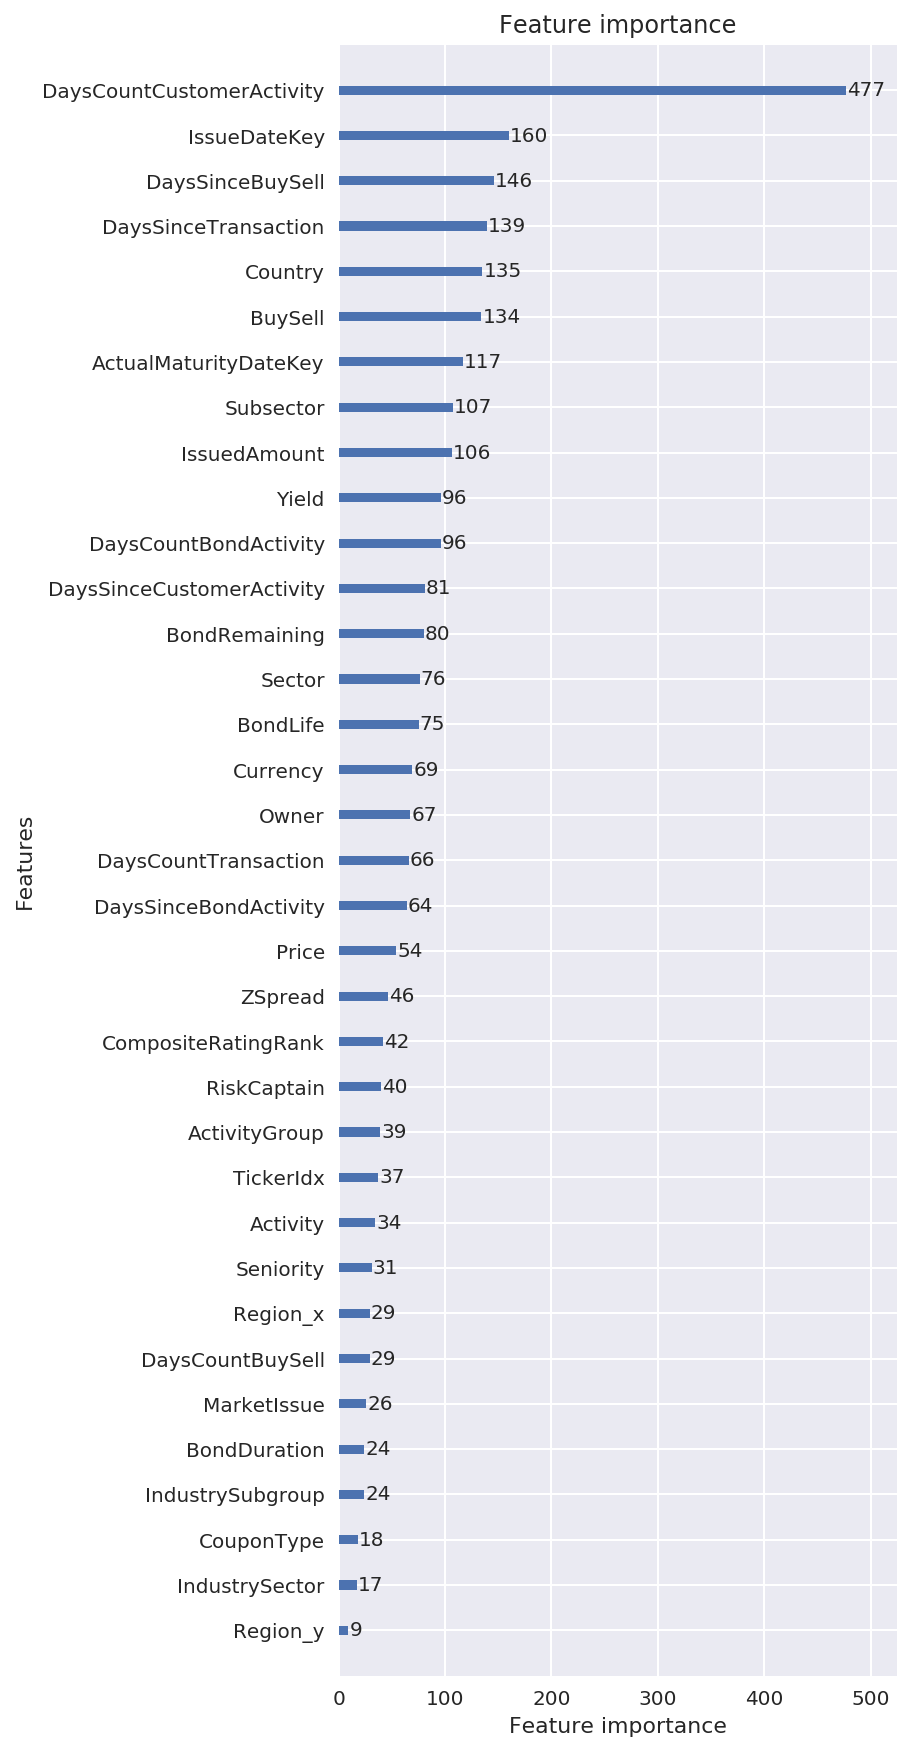

In [57]:
from lightgbm import plot_importance
plot_importance(output[0][1], figsize=(5,15))

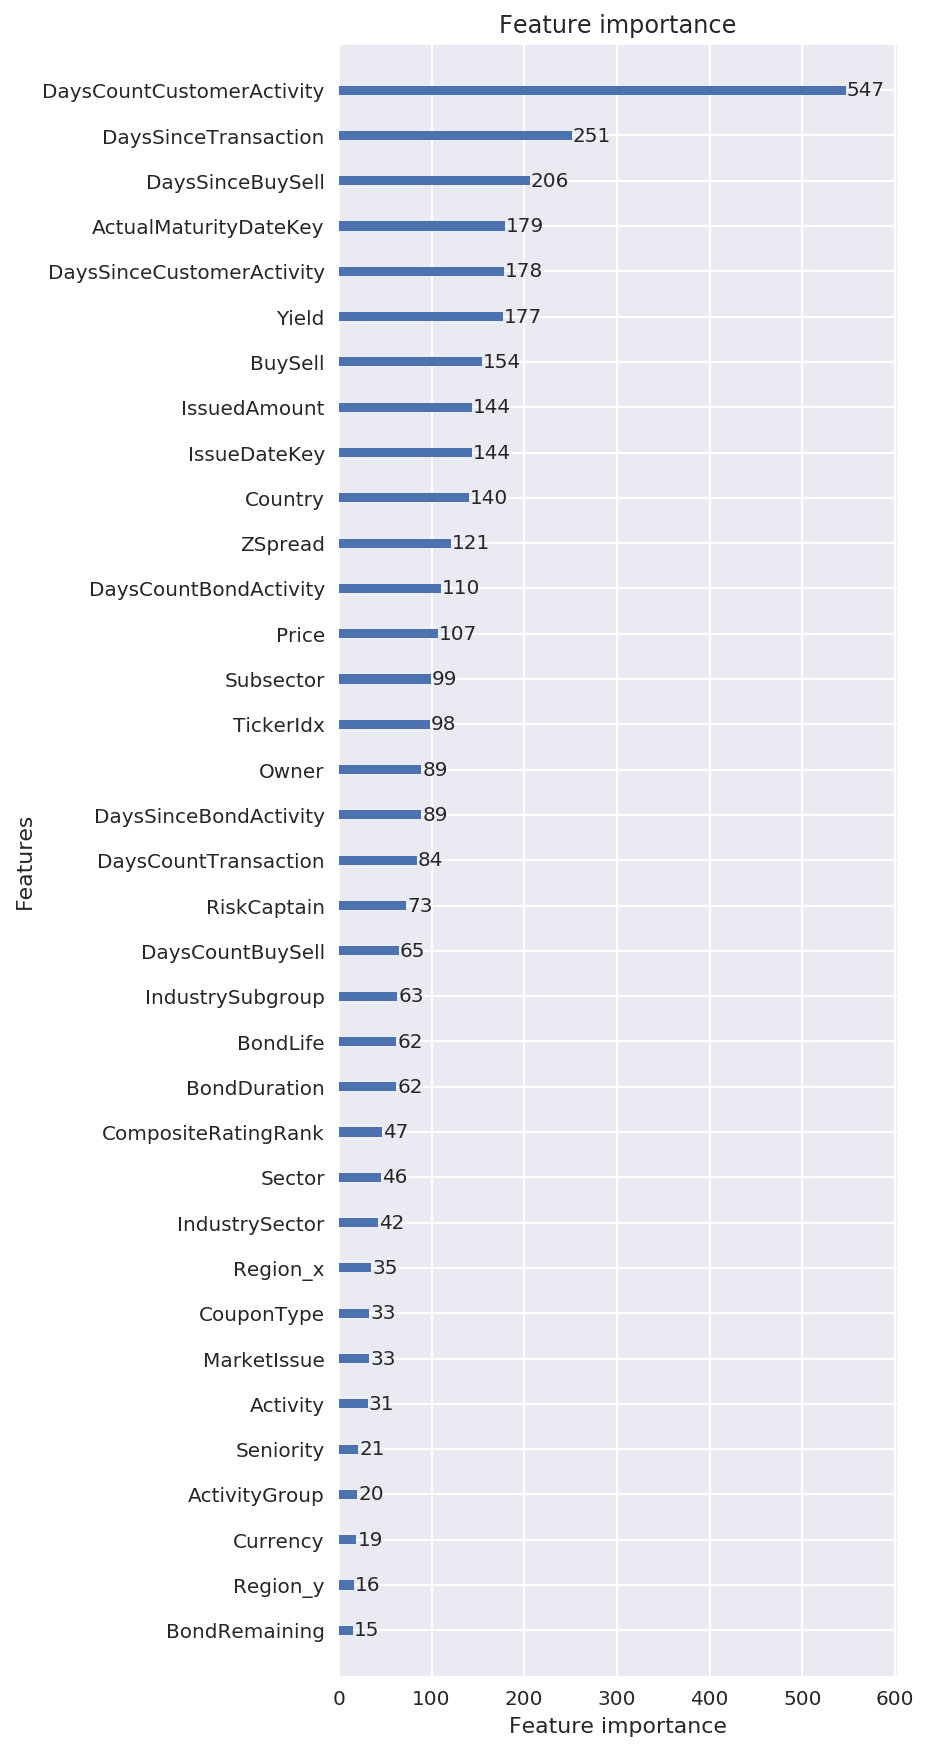

In [58]:
plot_importance(output[-1][1], figsize=(5,15))